<a href="https://colab.research.google.com/github/pragy10/neural_symbolic/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Purely Neural - TRANSFORMER

##Dataset Preprocessing

In [6]:
import pandas as pd
import numpy as np
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,confusion_matrix, classification_report
import pickle

In [7]:
train_data = pd.read_csv(r"C:\Users\pragy\cloud_architecture\neural_symbolic\data\train_data.csv")
test_data = pd.read_csv(r"C:\Users\pragy\cloud_architecture\neural_symbolic\data\test_data.csv")

In [8]:
# ----------------------
# 1. Load & clean
# ----------------------
# df = pd.read_csv("train_data.csv")
df = train_data

In [9]:
# Sort per student chronologically
df = df.sort_values(["student_id", "start_time"]).reset_index(drop=True)

In [10]:
# Convert correct column to boolean (fill NA with False)
df["correct"] = df["correct"].fillna(False).astype(bool)

C:\Users\pragy\AppData\Local\Temp\ipykernel_6292\2319459733.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["correct"] = df["correct"].fillna(False).astype(bool)


In [11]:
# ----------------------
# 2. Handle missing values
# ----------------------
num_cols = df.select_dtypes(include=["float64", "int64"]).columns
cat_cols = df.select_dtypes(include=["object", "bool"]).columns

# Fill numeric with median
for col in num_cols:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median())

# Fill categorical with "unknown"
for col in cat_cols:
    if df[col].isnull().any():
        df[col] = df[col].fillna("unknown")

In [12]:
# ----------------------
# 3. Encode categoricals
# ----------------------
label_encoders = {}
for col in ["problem_type", "content_source", "skills", "tutoring_types","answer_before_tutoring","account_creation_date"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Save encoders
with open("label_encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)


In [13]:
# ----------------------
# 4. Scale numeric features
# ----------------------
numeric_features = [
    "time_on_task",
    "fraction_of_hints_used",
    "attempt_count",
    "student_answer_count",
    "mean_correct",
    "mean_time_on_task",
    "started_problem_sets_count",
    "completed_problem_sets_count",
    "started_skill_builders_count",
    "mastered_skill_builders_count",
    "answered_problems_count",
    "mean_problem_correctness",
    "mean_problem_time_on_task",
    "mean_class_score"
]

scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])
# Save the fitted scaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [14]:
df.groupby("student_id").size().describe()


count    10000.00000
mean        11.04740
std          4.59929
min          5.00000
25%          7.00000
50%         10.00000
75%         15.00000
max         20.00000
dtype: float64

In [15]:
print(df.dtypes)


log_id                             int64
student_id                         int64
assignment_id                      int64
problem_id                         int64
start_time                        object
time_on_task                     float64
answer_before_tutoring             int32
fraction_of_hints_used           float64
attempt_count                    float64
answer_given                        bool
problem_completed                   bool
correct                             bool
next_correct                        bool
content_source                     int32
skills                             int32
problem_type                       int32
tutoring_types                     int32
student_answer_count             float64
mean_correct                     float64
mean_time_on_task                float64
class_id                           int64
account_creation_date              int32
started_problem_sets_count       float64
completed_problem_sets_count     float64
started_skill_bu

In [16]:
for col in df.select_dtypes(include="bool").columns:
    df[col] = df[col].astype(int)

In [17]:
df.to_csv("transformer_train_data.csv", index=False)


In [18]:
# ----------------------
# 5. Sequence dataset for Transformer
# ----------------------
class StudentSequenceDataset(Dataset):
    def __init__(self, df, context=12, target_col="next_correct"):
        self.context = context
        self.target_col = target_col

        # Group per student
        self.groups = []
        for sid, group in df.groupby("student_id"):
            features = group.drop(columns=["start_time","log_id", "student_id", "account_creation_date"]).values

            targets = group[target_col].astype(int).values

            if len(group) < context:
                # Pad sequences with zeros
                pad_len = context - len(group)
                padded_x = np.vstack([np.zeros((pad_len, features.shape[1])), features])
                padded_y = targets[-1]  # last available target
                self.groups.append((padded_x, padded_y))
            else:
                for i in range(len(group) - context):
                    x = features[i:i+context]
                    y = targets[i+context]
                    self.groups.append((x, y))

    def __len__(self):
        return len(self.groups)

    def __getitem__(self, idx):
        x, y = self.groups[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Example usage
dataset = StudentSequenceDataset(df, context=12, target_col="next_correct")
print("Dataset size:", len(dataset))
print("One sample X shape:", dataset[0][0].shape, "Target:", dataset[0][1])

Dataset size: 21430
One sample X shape: torch.Size([12, 26]) Target: tensor(1.)


## Training transformer


In [19]:

# ----------------------
# 1. Dataset
# ----------------------
class SAKTDatasetAllFeatures(Dataset):
    def __init__(self, df, numeric_cols, categorical_cols, context=12, target_col="next_correct"):
        self.context = context
        self.samples = []
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols

        # Convert boolean columns to int
        for col in df.select_dtypes(include="bool").columns:
            df[col] = df[col].astype(int)

        # Store categorical mappings (int IDs)
        self.cat_maps = {col: sorted(df[col].unique()) for col in categorical_cols}
        self.cat_to_idx = {
            col: {cat: i for i, cat in enumerate(self.cat_maps[col])} for col in categorical_cols
        }

        # Group per student
        for sid, group in df.groupby("student_id"):
            # Convert categorical to IDs
            cat_data = []
            for col in categorical_cols:
                cat_data.append(np.array([self.cat_to_idx[col][v] for v in group[col].values]))
            cat_data = np.stack(cat_data, axis=1)  # shape: [seq_len, num_cats]

            # Numeric features
            num_data = group[numeric_cols].values.astype(np.float32)

            # Target
            targets = group[target_col].values

            # Pad sequences shorter than context
            if len(group) < context:
                pad_len = context - len(group)
                cat_data = np.concatenate([np.zeros((pad_len, len(categorical_cols)), dtype=int), cat_data])
                num_data = np.concatenate([np.zeros((pad_len, len(numeric_cols)), dtype=np.float32), num_data])
                y = targets[-1]
                self.samples.append((num_data, cat_data, y))
            else:
                for i in range(len(group) - context):
                    x_num = num_data[i:i+context]
                    x_cat = cat_data[i:i+context]
                    y = targets[i+context]
                    self.samples.append((x_num, x_cat, y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        num_data, cat_data, y = self.samples[idx]
        return (
            torch.tensor(num_data, dtype=torch.float32),
            torch.tensor(cat_data, dtype=torch.long),
            torch.tensor(y, dtype=torch.float32)
        )

# ----------------------
# 2. Transformer model
# ----------------------
class SAKTAllFeatures(nn.Module):
    def __init__(self, numeric_dim, categorical_vocab_sizes, d_model=64, n_heads=4, num_layers=2):
        super().__init__()
        self.d_model = d_model

        # Embeddings for categorical features
        self.cat_embeddings = nn.ModuleList([
            nn.Embedding(vocab_size, d_model) for vocab_size in categorical_vocab_sizes.values()
        ])

        # Linear projection for numeric features
        self.num_linear = nn.Linear(numeric_dim, d_model)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Output layer
        self.fc = nn.Linear(d_model, 1)

    def forward(self, numeric, categorical):
        # Embed categorical features
        cat_embeds = []
        for i, emb_layer in enumerate(self.cat_embeddings):
            cat_embeds.append(emb_layer(categorical[:, :, i]))
        cat_embeds = torch.stack(cat_embeds, dim=0).sum(dim=0)  # sum over categories

        # Project numeric features
        num_proj = self.num_linear(numeric)

        # Combine numeric + categorical
        x = num_proj + cat_embeds

        # Transformer encoder
        x = self.encoder(x)
        x = x[:, -1, :]  # last time step

        # Output
        out = torch.sigmoid(self.fc(x))
        return out.squeeze(-1)

# ----------------------
# 3. Training with Validation
# ----------------------
def train_model_all_features(
    df,
    numeric_cols,
    categorical_cols,
    num_epochs=10,
    batch_size=32,
    lr=1e-3,
    context=12,
    val_split=0.2
):
    """
    Train Transformer model (SAKTAllFeatures) using both numeric and categorical features.
    """

    # ----------------------
    # Dataset
    # ----------------------
    dataset = SAKTDatasetAllFeatures(df, numeric_cols, categorical_cols, context=context, target_col="next_correct")
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    # ----------------------
    # Model
    # ----------------------
    categorical_vocab_sizes = {col: df[col].nunique() for col in categorical_cols}
    model = SAKTAllFeatures(
        numeric_dim=len(numeric_cols),
        categorical_vocab_sizes=categorical_vocab_sizes,
        d_model=64,
        n_heads=4,
        num_layers=2
    )

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # ----------------------
    # Metric lists
    # ----------------------
    train_losses, val_losses = [], []
    val_accuracies, val_precisions, val_recalls, val_f1s, val_aucs = [], [], [], [], []

    # ----------------------
    # Training loop
    # ----------------------
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for num_data, cat_data, y in train_loader:
            optimizer.zero_grad()
            preds = model(num_data, cat_data)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * len(y)

        avg_train_loss = total_loss / train_size
        train_losses.append(avg_train_loss)

        # ----------------------
        # Validation
        # ----------------------
        model.eval()
        all_preds, all_targets = [], []
        with torch.no_grad():
            for num_data, cat_data, y in val_loader:
                preds = model(num_data, cat_data)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(y.cpu().numpy())

        all_preds = np.array(all_preds)
        all_targets = np.array(all_targets)

        val_loss = criterion(torch.tensor(all_preds), torch.tensor(all_targets)).item()
        val_losses.append(val_loss)

        pred_labels = np.round(all_preds)

        val_acc = accuracy_score(all_targets, pred_labels)
        val_prec = precision_score(all_targets, pred_labels, zero_division=0)
        val_rec = recall_score(all_targets, pred_labels, zero_division=0)
        val_f1 = f1_score(all_targets, pred_labels, zero_division=0)

        try:
            val_auc = roc_auc_score(all_targets, all_preds)
        except ValueError:
            val_auc = float("nan")

        # Save metrics
        val_accuracies.append(val_acc)
        val_precisions.append(val_prec)
        val_recalls.append(val_rec)
        val_f1s.append(val_f1)
        val_aucs.append(val_auc)

        print(
            f"Epoch {epoch+1}/{num_epochs} "
            f"- Train Loss: {avg_train_loss:.4f} "
            f"- Val Loss: {val_loss:.4f} "
            f"- Val Acc: {val_acc:.4f} "
            f"- Val AUC: {val_auc:.4f}"
        )

    return model, {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "val_precisions": val_precisions,
        "val_recalls": val_recalls,
        "val_f1s": val_f1s,
        "val_aucs": val_aucs
    }


In [20]:
df = pd.read_csv("transformer_train_data.csv")
numeric_cols = [
    "time_on_task", "fraction_of_hints_used", "attempt_count",
    "student_answer_count", "mean_correct", "mean_time_on_task",
    "started_problem_sets_count", "completed_problem_sets_count",
    "started_skill_builders_count", "mastered_skill_builders_count",
    "answered_problems_count", "mean_problem_correctness",
    "mean_problem_time_on_task", "mean_class_score"
]

categorical_cols = ["problem_type", "content_source", "skills", "tutoring_types"]

# Train
trained_model,history= train_model_all_features(df, numeric_cols, categorical_cols, num_epochs=20, batch_size=32, lr=1e-3, context=12)




Epoch 1/20 - Train Loss: 0.5792 - Val Loss: 0.5525 - Val Acc: 0.7191 - Val AUC: 0.7864
Epoch 2/20 - Train Loss: 0.5405 - Val Loss: 0.5587 - Val Acc: 0.7049 - Val AUC: 0.7922
Epoch 3/20 - Train Loss: 0.5258 - Val Loss: 0.5430 - Val Acc: 0.7193 - Val AUC: 0.7957
Epoch 4/20 - Train Loss: 0.5142 - Val Loss: 0.5403 - Val Acc: 0.7240 - Val AUC: 0.7998
Epoch 5/20 - Train Loss: 0.5064 - Val Loss: 0.5398 - Val Acc: 0.7245 - Val AUC: 0.8033
Epoch 6/20 - Train Loss: 0.4954 - Val Loss: 0.5523 - Val Acc: 0.7210 - Val AUC: 0.7980
Epoch 7/20 - Train Loss: 0.4867 - Val Loss: 0.5558 - Val Acc: 0.7247 - Val AUC: 0.7995
Epoch 8/20 - Train Loss: 0.4788 - Val Loss: 0.5594 - Val Acc: 0.7207 - Val AUC: 0.7975
Epoch 9/20 - Train Loss: 0.4738 - Val Loss: 0.5576 - Val Acc: 0.7263 - Val AUC: 0.7952
Epoch 10/20 - Train Loss: 0.4649 - Val Loss: 0.5596 - Val Acc: 0.7163 - Val AUC: 0.7952
Epoch 11/20 - Train Loss: 0.4597 - Val Loss: 0.5573 - Val Acc: 0.7154 - Val AUC: 0.7926
Epoch 12/20 - Train Loss: 0.4515 - Val Lo

In [21]:

def evaluate_model(model, dataset, batch_size=64):
    loader = DataLoader(dataset, batch_size=batch_size)
    model.eval()

    all_preds, all_targets = [], []
    with torch.no_grad():
        for skills, correct, y in loader:
            preds = model(skills, correct)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    # Round predictions for accuracy
    acc = accuracy_score(all_targets, np.round(all_preds))

    # AUC (may fail if all y are 0 or 1)
    try:
        auc = roc_auc_score(all_targets, all_preds)
    except ValueError:
        auc = float("nan")

    return acc, auc


In [22]:
# Build dataset again
dataset = SAKTDatasetAllFeatures(df, numeric_cols, categorical_cols, context=12, target_col="next_correct")

# Evaluate
acc, auc = evaluate_model(trained_model, dataset)
print(f"Final Accuracy: {acc:.4f}, Final AUC: {auc:.4f}")

Final Accuracy: 0.8126, Final AUC: 0.8903


##Testing the model

###Test dataset preprocessing

In [23]:
df1 = test_data
df1 = df1.sort_values(["student_id", "start_time"]).reset_index(drop=True)
df1["correct"] = df1["correct"].fillna(False).astype(bool)

num_cols = df1.select_dtypes(include=["float64", "int64"]).columns
cat_cols = df1.select_dtypes(include=["object", "bool"]).columns

for col in num_cols:
    if df1[col].isnull().any():
        df1[col] = df1[col].fillna(df1[col].median())

for col in cat_cols:
    if df1[col].isnull().any():
        df1[col] = df1[col].fillna("unknown")


# Load encoders and scaler
with open("label_encoders.pkl", "rb") as f:
    label_encoders = pickle.load(f)

for col in ["problem_type", "content_source", "skills", "tutoring_types","answer_before_tutoring","account_creation_date"]:
    df1[col] = df1[col].astype(str)

    # Replace unseen categories with "unknown"
    df1[col] = df1[col].apply(lambda x: x if x in label_encoders[col].classes_ else "unknown")

    # If "unknown" not in classes_, add it
    if "unknown" not in label_encoders[col].classes_:
        label_encoders[col].classes_ = np.append(label_encoders[col].classes_, "unknown")

    # Transform using training encoder
    df1[col] = label_encoders[col].transform(df1[col])



with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# Transform test data using **fitted scaler**
df1[numeric_features] = scaler.transform(df1[numeric_features])

df1 = df1.drop(columns=["start_time"])
for col in df1.select_dtypes(include="bool").columns:
    df1[col] = df1[col].astype(int)

df1.to_csv("transformer_test_data.csv", index=False)



C:\Users\pragy\AppData\Local\Temp\ipykernel_6292\1595089311.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1["correct"] = df1["correct"].fillna(False).astype(bool)


In [24]:
# ----------------------
# 1. Prepare Test Dataset
# ----------------------
test_df = pd.read_csv("transformer_test_data.csv")  # preprocessed already
context = 12  # same as training

numeric_cols = [
    "time_on_task", "fraction_of_hints_used", "attempt_count",
    "student_answer_count", "mean_correct", "mean_time_on_task",
    "started_problem_sets_count", "completed_problem_sets_count",
    "started_skill_builders_count", "mastered_skill_builders_count",
    "answered_problems_count", "mean_problem_correctness",
    "mean_problem_time_on_task", "mean_class_score"
]

categorical_cols = ["problem_type", "content_source", "skills", "tutoring_types"]


test_dataset = SAKTDatasetAllFeatures(
    test_df, numeric_cols=numeric_cols, categorical_cols=categorical_cols,
    context=context, target_col='next_correct'
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ----------------------
# 2. Run Predictions
# ----------------------
model = trained_model
model.eval()

all_preds, all_targets = [], []

with torch.no_grad():
    for numeric, categorical, y in test_loader:
        preds = model(numeric, categorical)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y.cpu().numpy())

# ----------------------
# 3. Convert to 0/1 predictions
# ----------------------
pred_labels = [1 if p > 0.5 else 0 for p in all_preds]

# ----------------------
# 4. Evaluate
# ----------------------

from sklearn.metrics import accuracy_score, roc_auc_score
accuracy = accuracy_score(all_targets, pred_labels)
auc = roc_auc_score(all_targets, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc:.4f}")



Test Accuracy: 0.6843
Test AUC: 0.7419


In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# ----------------------
# 1. Prepare Test Dataset
# ----------------------
test_df = pd.read_csv("transformer_test_data.csv")  # preprocessed already
context = 12  # same as training

numeric_cols = [
    "time_on_task", "fraction_of_hints_used", "attempt_count",
    "student_answer_count", "mean_correct", "mean_time_on_task",
    "started_problem_sets_count", "completed_problem_sets_count",
    "started_skill_builders_count", "mastered_skill_builders_count",
    "answered_problems_count", "mean_problem_correctness",
    "mean_problem_time_on_task", "mean_class_score"
]

categorical_cols = ["problem_type", "content_source", "skills", "tutoring_types"]

test_dataset = SAKTDatasetAllFeatures(
    test_df, numeric_cols=numeric_cols, categorical_cols=categorical_cols,
    context=context, target_col="next_correct"
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [26]:

# ----------------------
# Evaluation Function
# ----------------------
def evaluate_transformer(model, dataloader, criterion, device="cpu"):
    model.eval()
    all_preds, all_targets = [], []
    total_loss = 0.0

    with torch.no_grad():
        for numeric, categorical, y in dataloader:
            numeric, categorical, y = numeric.to(device), categorical.to(device), y.to(device)

            preds = model(numeric, categorical).squeeze()
            loss = criterion(preds, y)
            total_loss += loss.item() * len(y)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    pred_labels = (all_preds > 0.5).astype(int)

    avg_loss = total_loss / len(dataloader.dataset)
    accuracy = accuracy_score(all_targets, pred_labels)
    precision = precision_score(all_targets, pred_labels, zero_division=0)
    recall = recall_score(all_targets, pred_labels, zero_division=0)
    f1 = f1_score(all_targets, pred_labels, zero_division=0)
    auc = roc_auc_score(all_targets, all_preds)

    return avg_loss, accuracy, precision, recall, f1, auc, all_preds,all_targets

# ----------------------
# Final Evaluation
# ----------------------
criterion = nn.BCELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

final_loss, final_acc, final_prec, final_rec, final_f1, final_auc,final_pred,final_target = evaluate_transformer(
    model, test_loader, criterion, device
)

print("="*60)
print("FINAL TRANSFORMER EVALUATION")
print("="*60)
print(f"Test Loss:      {final_loss:.4f}")
print(f"Test Accuracy:  {final_acc:.4f}")
print(f"Test Precision: {final_prec:.4f}")
print(f"Test Recall:    {final_rec:.4f}")
print(f"Test F1-Score:  {final_f1:.4f}")
print(f"Test AUC-ROC:   {final_auc:.4f}")


C:\Users\pragy\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\transformer.py:720: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  return torch._transformer_encoder_layer_fwd(


FINAL TRANSFORMER EVALUATION
Test Loss:      0.7516
Test Accuracy:  0.6843
Test Precision: 0.6855
Test Recall:    0.8413
Test F1-Score:  0.7554
Test AUC-ROC:   0.7419


In [27]:
final_pred_binary = [1 if p > 0.5 else 0 for p in final_pred]
print(f"\n=== DETAILED CLASSIFICATION REPORT ===")
print(classification_report(final_target, final_pred_binary, target_names=['Incorrect', 'Correct'], digits=4))


=== DETAILED CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

   Incorrect     0.6812    0.4677    0.5546       868
     Correct     0.6855    0.8413    0.7554      1197

    accuracy                         0.6843      2065
   macro avg     0.6834    0.6545    0.6550      2065
weighted avg     0.6837    0.6843    0.6710      2065



In [28]:
cm = confusion_matrix(final_target, final_pred_binary)
print(f"\n=== CONFUSION MATRIX ===")
print(f"True Negatives (TN):  {cm[0,0]}")
print(f"False Positives (FP): {cm[0,1]}")
print(f"False Negatives (FN): {cm[1,0]}")
print(f"True Positives (TP):  {cm[1,1]}")
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\nSpecificity (True Negative Rate): {specificity:.4f}")
print(f"Sensitivity (True Positive Rate): {sensitivity:.4f}")


=== CONFUSION MATRIX ===
True Negatives (TN):  406
False Positives (FP): 462
False Negatives (FN): 190
True Positives (TP):  1007

Specificity (True Negative Rate): 0.4677
Sensitivity (True Positive Rate): 0.8413


In [29]:
print(f"\n=== SAMPLE PREDICTIONS ANALYSIS ===")

# Show some example predictions
sample_size = 20
print(f"First {sample_size} predictions vs actual:")
print("Pred | Actual | Prob")
print("-" * 20)
for i in range(min(sample_size, len(final_pred))):
    pred_prob = final_pred[i]
    pred_class = 1 if pred_prob > 0.5 else 0
    actual = int(final_target[i])
    print(f"{pred_class:4d} | {actual:6d} | {pred_prob:.3f}")


=== SAMPLE PREDICTIONS ANALYSIS ===
First 20 predictions vs actual:
Pred | Actual | Prob
--------------------
   0 |      0 | 0.242
   1 |      1 | 0.821
   0 |      1 | 0.146
   0 |      1 | 0.395
   0 |      1 | 0.355
   0 |      0 | 0.443
   1 |      1 | 0.824
   1 |      1 | 0.752
   1 |      1 | 0.920
   0 |      1 | 0.011
   1 |      1 | 0.990
   1 |      1 | 0.879
   1 |      0 | 0.822
   1 |      1 | 0.861
   0 |      0 | 0.115
   1 |      1 | 0.990
   0 |      1 | 0.319
   0 |      1 | 0.109
   0 |      1 | 0.405
   1 |      0 | 0.752


In [30]:
performance_summary = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Specificity', 'Sensitivity'],
    'Score': [final_acc, final_prec, final_rec, final_f1, final_auc, specificity, sensitivity]
}

print(f"\n=== PERFORMANCE SUMMARY ===")
for metric, score in zip(performance_summary['Metric'], performance_summary['Score']):
    print(f"{metric:12s}: {score:.4f}")


=== PERFORMANCE SUMMARY ===
Accuracy    : 0.6843
Precision   : 0.6855
Recall      : 0.8413
F1-Score    : 0.7554
AUC-ROC     : 0.7419
Specificity : 0.4677
Sensitivity : 0.8413


In [31]:
def predict_next_correct_transformer(model, new_data, scaler, label_encoders, numeric_cols, categorical_cols, context, device):
    """
    Inference function for Transformer model on new student data.

    Args:
        model: Trained Transformer model
        new_data (pd.DataFrame): New student interaction history
        scaler: Fitted scaler for numeric features
        label_encoders (dict): Dict of fitted label encoders for categorical features
        numeric_cols (list): Numeric feature column names
        categorical_cols (list): Categorical feature column names
        context (int): Sequence length used during training
        device: "cpu" or "cuda"

    Returns:
        float: Probability of next response being correct
    """
    model.eval()

    with torch.no_grad():
        processed_data = new_data.copy()

        # --- 1. Scale numeric features ---
        if len(numeric_cols) > 0:
            processed_data[numeric_cols] = scaler.transform(processed_data[numeric_cols])

        # --- 2. Encode categorical features ---
        for col in categorical_cols:
            if col in processed_data.columns:
                le = label_encoders[col]
                processed_data[col] = processed_data[col].map(
                    lambda x: le.transform([x])[0] if x in le.classes_ else 0
                )

        # --- 3. Take last `context` steps ---
        numeric_vals = processed_data[numeric_cols].values[-context:]
        categorical_vals = processed_data[categorical_cols].values[-context:]

        # If sequence shorter than context, pad with zeros
        if numeric_vals.shape[0] < context:
            pad_len = context - numeric_vals.shape[0]
            numeric_vals = np.vstack([np.zeros((pad_len, numeric_vals.shape[1])), numeric_vals])
            categorical_vals = np.vstack([np.zeros((pad_len, categorical_vals.shape[1])), categorical_vals])

        # --- 4. Convert to tensors ---
        x_num = torch.tensor(numeric_vals).unsqueeze(0).float().to(device)   # [1, context, num_features]
        x_cat = torch.tensor(categorical_vals).unsqueeze(0).long().to(device) # [1, context, cat_features]

        # --- 5. Run through model ---
        prediction = model(x_num, x_cat)

        return prediction.cpu().item()


In [32]:
evaluation_results = {
    'final_metrics': {
        'accuracy': final_acc,
        'precision': final_prec,
        'recall': final_rec,
        'f1': final_f1,
        'auc': final_auc,
        'specificity': specificity,
        'sensitivity': sensitivity
    },
    'confusion_matrix': cm.tolist(),

}

torch.save(evaluation_results, 'transformer_evaluation_results.pth')

In [33]:
# Assume these lists were collected during training
# train_losses, val_losses, val_accuracies, val_precisions, val_recalls, val_f1s, val_aucs
# And `cm` is confusion matrix from test evaluation
train_losses = history["train_losses"]
val_losses = history["val_losses"]
val_accuracies = history["val_accuracies"]
val_recalls = history["val_recalls"]
val_f1s = history["val_f1s"]
val_precisions = history["val_precisions"]
val_aucs = history["val_aucs"]
epochs_range = list(range(1, len(train_losses) + 1))

# -----------------------------
# 1. Training curves (loss)
# -----------------------------
training_curves_data = {
    'epoch': epochs_range + epochs_range,  # Duplicate for train + validation
    'loss': train_losses + val_losses,
    'type': ['Train'] * len(train_losses) + ['Validation'] * len(val_losses)
}

# -----------------------------
# 2. Validation metrics over epochs
# -----------------------------
metrics_data = {
    'epoch': epochs_range,
    'accuracy': val_accuracies,
    'auc': val_aucs,
    'precision': val_precisions,
    'recall': val_recalls,
    'f1': val_f1s
}

# -----------------------------
# 3. Confusion matrix (test set)
# -----------------------------
cm_data = {
    'Predicted_Incorrect': [cm[0, 0], cm[1, 0]],
    'Predicted_Correct': [cm[0, 1], cm[1, 1]],
    'Actual': ['Actual_Incorrect', 'Actual_Correct']
}

# -----------------------------
# 4. Sanity check
# -----------------------------
print(f"\n=== DATA PREPARED FOR TRANSFORMER VISUALIZATION ===")
print(f"Training epochs: {len(epochs_range)}")
print(f"Training curves data points: {len(training_curves_data['epoch'])}")
print(f"Metrics data points: {len(metrics_data['epoch'])}")



=== DATA PREPARED FOR TRANSFORMER VISUALIZATION ===
Training epochs: 20
Training curves data points: 40
Metrics data points: 20


<function matplotlib.pyplot.show(close=None, block=None)>

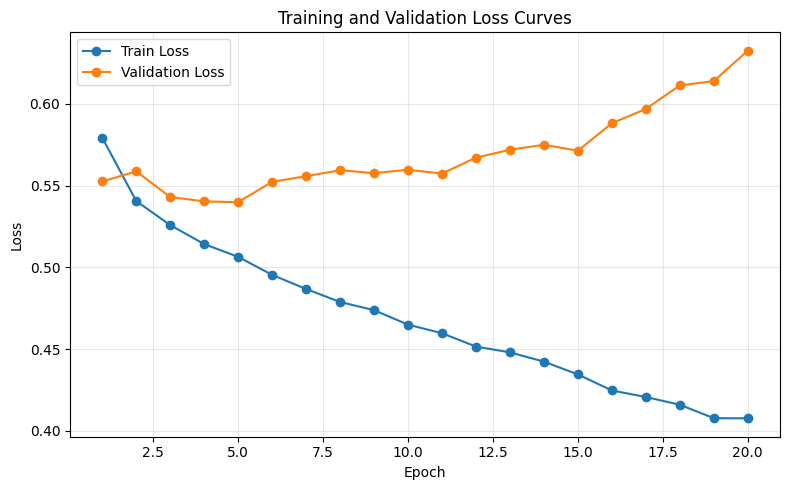

In [34]:

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(training_curves_data['epoch'][:len(train_losses)], training_curves_data['loss'][:len(train_losses)], label='Train Loss', marker='o')
plt.plot(training_curves_data['epoch'][len(train_losses):], training_curves_data['loss'][len(train_losses):], label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show

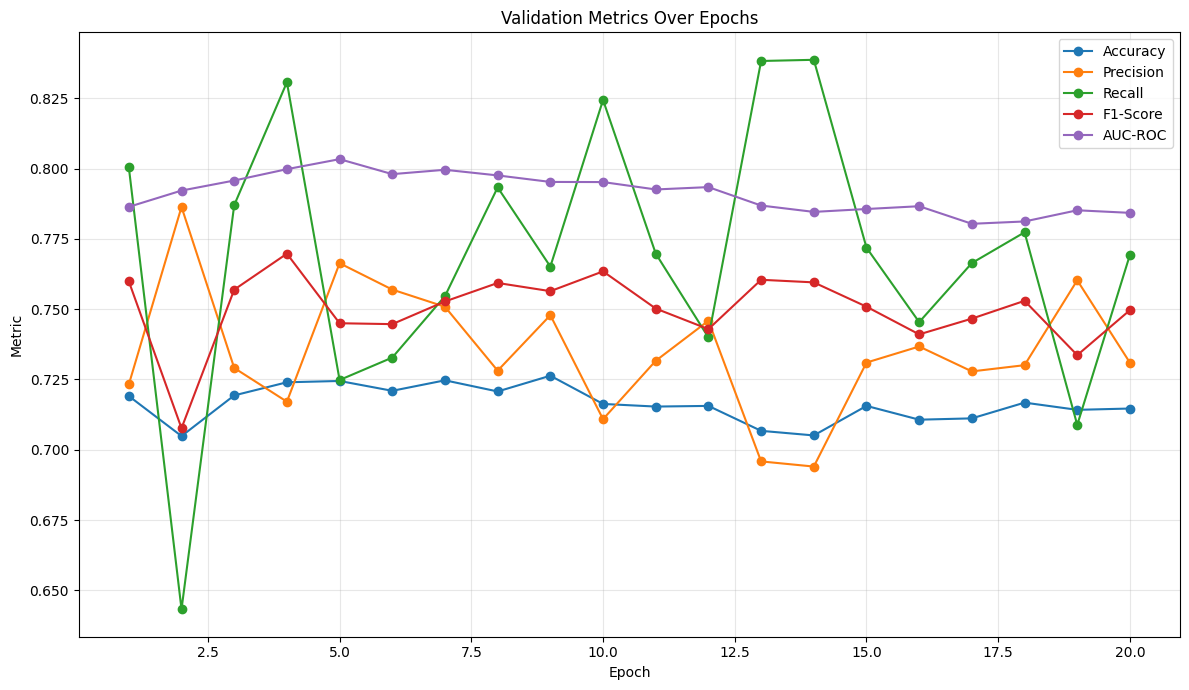

In [35]:

plt.figure(figsize=(12, 7))
plt.plot(metrics_data['epoch'], metrics_data['accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_data['epoch'], metrics_data['precision'], label='Precision', marker='o')
plt.plot(metrics_data['epoch'], metrics_data['recall'], label='Recall', marker='o')
plt.plot(metrics_data['epoch'], metrics_data['f1'], label='F1-Score', marker='o')
plt.plot(metrics_data['epoch'], metrics_data['auc'], label='AUC-ROC', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Validation Metrics Over Epochs')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

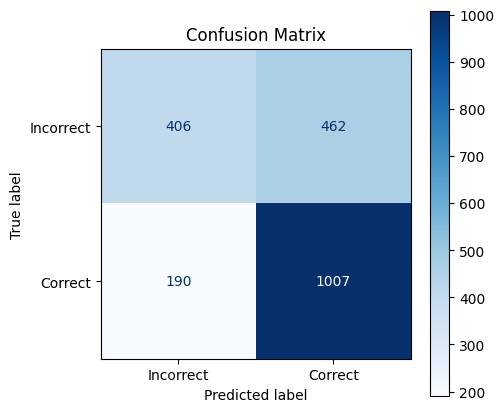

In [36]:

import seaborn as sns
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

cm = np.array(evaluation_results['confusion_matrix'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Incorrect", "Correct"])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

📊 GENERATING TRANSFORMER RESEARCH PAPER VISUALIZATIONS


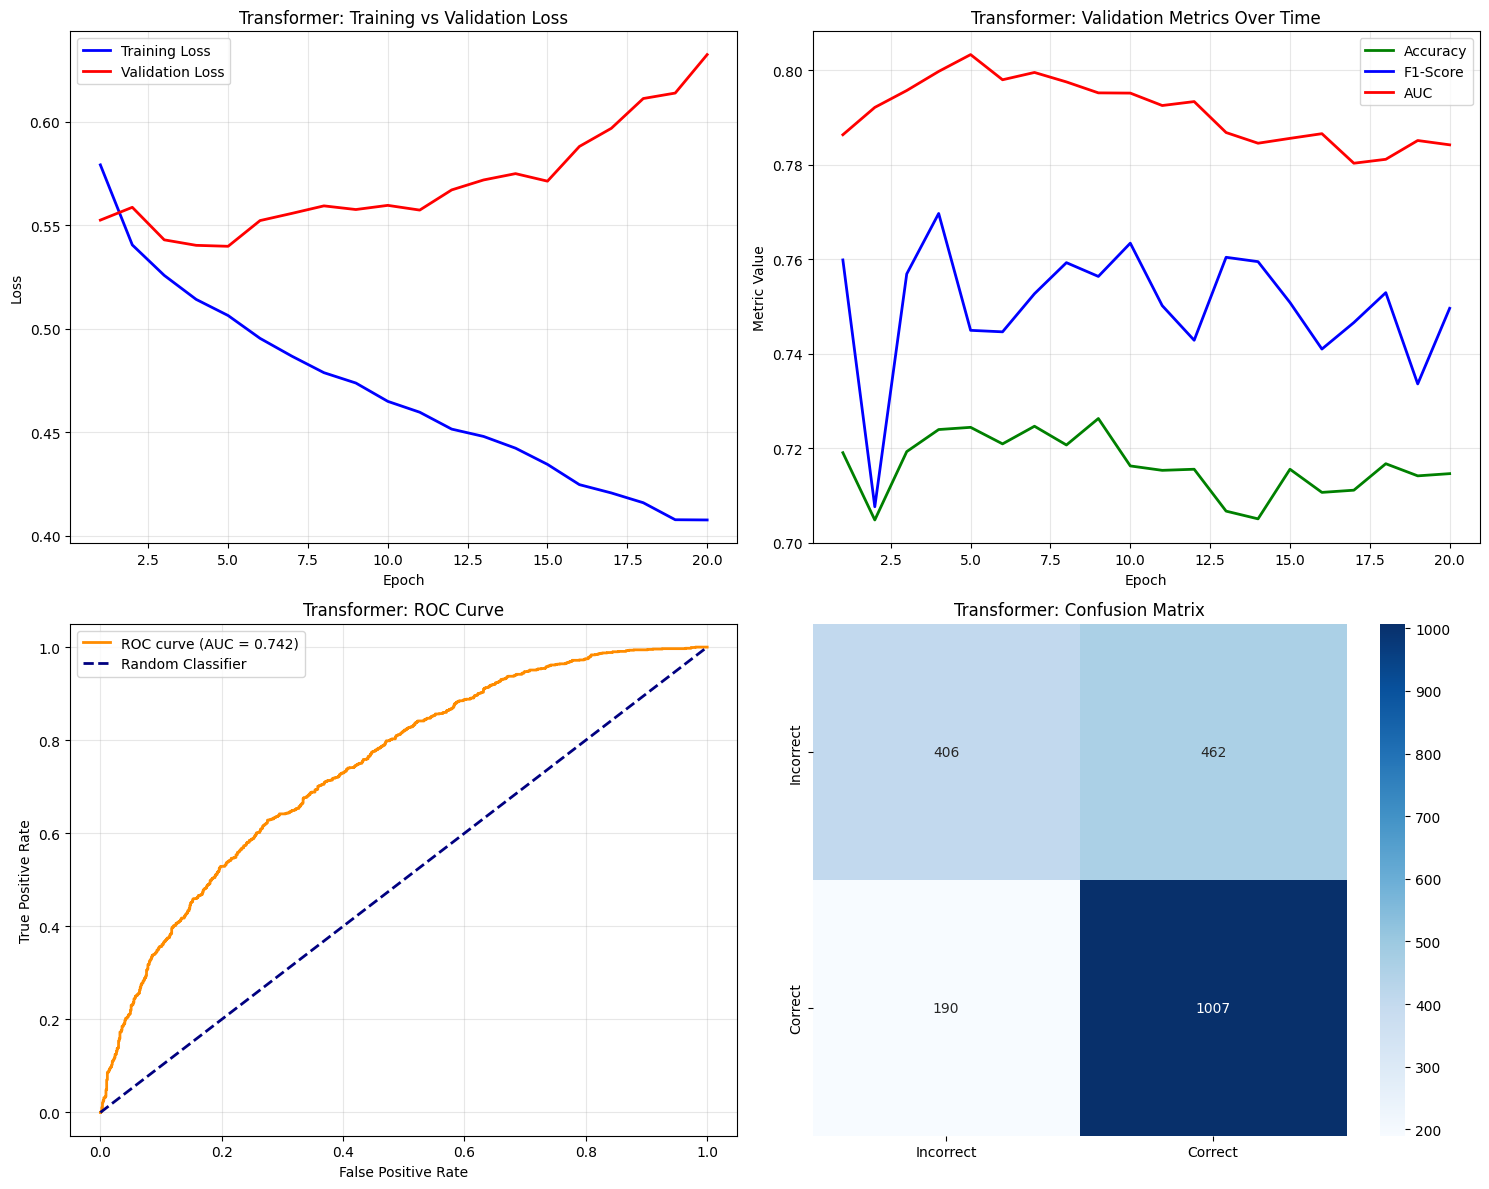

✅ Transformer comprehensive evaluation saved!


In [37]:
# ===== ADD COMPREHENSIVE EVALUATION AND VISUALIZATION =====
# Add after your existing evaluation code:

print("="*60)
print("📊 GENERATING TRANSFORMER RESEARCH PAPER VISUALIZATIONS")
print("="*60)

# Import required libraries for visualization
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate ROC and PR curves
fpr, tpr, _ = roc_curve(final_target, final_pred)
roc_auc = auc(fpr, tpr)
precision_curve, recall_curve, _ = precision_recall_curve(final_target, final_pred)

# Calculate total parameters (since it's not defined in your training function)
total_params = sum(p.numel() for p in trained_model.parameters() if p.requires_grad)

# Create comprehensive results
comprehensive_results = {
    'final_metrics': {
        'accuracy': final_acc,
        'precision': final_prec,
        'recall': final_rec,
        'f1': final_f1,
        'auc': final_auc,
        'specificity': specificity,
        'sensitivity': sensitivity
    },
    'confusion_matrix': cm.tolist(),
    'training_history': {
        'epochs': epochs_range,
        'train_losses': history['train_losses'],     # Extract from history dict
        'val_losses': history['val_losses'],         # Extract from history dict
        'val_accuracies': history['val_accuracies'], # Extract from history dict
        'val_precisions': history['val_precisions'], # Extract from history dict
        'val_recalls': history['val_recalls'],       # Extract from history dict
        'val_f1s': history['val_f1s'],               # Extract from history dict
        'val_aucs': history['val_aucs']              # Extract from history dict
    },
    'roc_data': {
        'fpr': fpr.tolist(),
        'tpr': tpr.tolist(), 
        'auc': roc_auc
    },
    'pr_data': {
        'precision': precision_curve.tolist(),
        'recall': recall_curve.tolist()
    },
    'model_info': {
        'name': 'Transformer',
        'parameters': f'{total_params:,}',  # Use calculated parameter count
        'architecture': 'SAKT Transformer'
    },
    'predictions': final_pred,
    'targets': final_target
}

# Save comprehensive results
torch.save(comprehensive_results, 'transformer_comprehensive_evaluation.pth')

# Generate publication-quality plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Loss curves
ax1.plot(epochs_range[:len(history['train_losses'])], history['train_losses'], 'b-', label='Training Loss', linewidth=2)
ax1.plot(epochs_range[:len(history['val_losses'])], history['val_losses'], 'r-', label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Transformer: Training vs Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Metrics over time
ax2.plot(epochs_range, history['val_accuracies'], 'g-', label='Accuracy', linewidth=2)
ax2.plot(epochs_range, history['val_f1s'], 'b-', label='F1-Score', linewidth=2)
ax2.plot(epochs_range, history['val_aucs'], 'r-', label='AUC', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Metric Value')
ax2.set_title('Transformer: Validation Metrics Over Time')
ax2.legend()
ax2.grid(True, alpha=0.3)

# ROC Curve
ax3.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
ax3.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('Transformer: ROC Curve')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4,
            xticklabels=['Incorrect', 'Correct'],
            yticklabels=['Incorrect', 'Correct'])
ax4.set_title('Transformer: Confusion Matrix')

plt.tight_layout()
plt.savefig('transformer_comprehensive_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Transformer comprehensive evaluation saved!")
